In [1]:
import torch 
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
import matplotlib.pyplot as plt

from pyhealth.models import Transformer
from pyhealth.interpret.methods.chefer import CheferRelevance


In [2]:
from pyhealth.datasets import MIMIC3Dataset

mimic3_ds = MIMIC3Dataset(
        root="https://storage.googleapis.com/pyhealth/Synthetic_MIMIC-III/",
        tables=["DIAGNOSES_ICD", "PROCEDURES_ICD", "PRESCRIPTIONS"],
        dev=True,
)

print (mimic3_ds.stat())
# data format
mimic3_ds.info()
from pyhealth.tasks import length_of_stay_prediction_mimic3_fn

mimic3_ds = mimic3_ds.set_task(task_fn=length_of_stay_prediction_mimic3_fn)
# stats info
print (mimic3_ds.stat())


{
    "patient_id": "p001",
    "visit_id": "v001",
    "diagnoses": [...],
    "labs": [...],
    "procedures": [...],
    "label": 1,
}

from pyhealth.datasets.splitter import split_by_patient
from pyhealth.datasets import split_by_patient, get_dataloader

# data split
train_dataset, val_dataset, test_dataset = split_by_patient(mimic3_ds, [0.8, 0.1, 0.1])

# create dataloaders (they are <torch.data.DataLoader> object)
train_loader = get_dataloader(train_dataset, batch_size=64, shuffle=True)
val_loader = get_dataloader(val_dataset, batch_size=64, shuffle=False)
test_loader = get_dataloader(test_dataset, batch_size=1, shuffle=False)
mimic3_ds.samples[0].keys()

from pyhealth.models import Transformer
model = Transformer(
        dataset=mimic3_ds,
        # look up what are available for "feature_keys" and "label_keys" in dataset.samples[0]
        feature_keys=["conditions", "procedures", "drugs"],
        label_key="label",
        mode="multiclass",
    )

print("Testing MIMIC3 STUFF")
sample = test_loader.dataset[0]

print(sample)

print("----")
print(model)
# exit(0)
from pyhealth.trainer import Trainer

trainer = Trainer(
    model=model,
    metrics=["accuracy", "f1_weighted"], # the metrics that we want to log
    )

trainer.train(
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    epochs=30,
    monitor="accuracy",
    monitor_criterion="max",optimizer_class=torch.optim.AdamW
)
data_iterator = iter(test_loader)
data = next(data_iterator)
print(data)
model(**data)

relevance = CheferRelevance(model)
# returns a list ofr now
# interpretability code here!
data['class_index'] = data['label']
rel_scores = relevance.get_relevance_matrix(**data)

# weigh and plot these scores and their corresponding feature list
print(rel_scores)

INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
finish basic patient information parsing : 1.2506768703460693s
finish parsing DIAGNOSES_ICD : 1.6561415195465088s
finish parsing PROCEDURES_ICD : 0.8813426494598389s
finish parsing PRESCRIPTIONS : 7.1212241649627686s


Mapping codes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 24326.65it/s]


Statistics of base dataset (dev=True):
	- Dataset: MIMIC3Dataset
	- Number of patients: 1000
	- Number of visits: 1054
	- Number of visits per patient: 1.0540
	- Number of events per visit in DIAGNOSES_ICD: 9.2068
	- Number of events per visit in PROCEDURES_ICD: 3.0380
	- Number of events per visit in PRESCRIPTIONS: 29.2457


Statistics of base dataset (dev=True):
	- Dataset: MIMIC3Dataset
	- Number of patients: 1000
	- Number of visits: 1054
	- Number of visits per patient: 1.0540
	- Number of events per visit in DIAGNOSES_ICD: 9.2068
	- Number of events per visit in PROCEDURES_ICD: 3.0380
	- Number of events per visit in PRESCRIPTIONS: 29.2457


dataset.patients: patient_id -> <Patient>

<Patient>
    - visits: visit_id -> <Visit> 
    - other patient-level info
    
    <Visit>
        - event_list_dict: table_name -> List[Event]
        - other visit-level info
    
        <Event>
            - code: str
            - other event-level info




Generating samples for length_of_stay_prediction_mimic3_fn: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 24884.78it/s]


Statistics of sample dataset:
	- Dataset: MIMIC3Dataset
	- Task: length_of_stay_prediction_mimic3_fn
	- Number of samples: 896
	- Number of patients: 886
	- Number of visits: 896
	- Number of visits per patient: 1.0113
	- conditions:
		- Number of conditions per sample: 9.7377
		- Number of unique conditions: 1699
		- Distribution of conditions (Top-10): [('4019', 324), ('41401', 167), ('25000', 151), ('4280', 147), ('5849', 121), ('2724', 118), ('42731', 110), ('51881', 89), ('53081', 88), ('2720', 85)]
	- procedures:
		- Number of procedures per sample: 3.5647
		- Number of unique procedures: 558
		- Distribution of procedures (Top-10): [('3893', 155), ('9671', 139), ('9604', 123), ('9904', 100), ('8856', 85), ('966', 64), ('3615', 61), ('3961', 59), ('3722', 58), ('3891', 55)]
	- drugs:
		- Number of drugs per sample: 32.5804
		- Number of unique drugs: 1911
		- Distribution of drugs (Top-10): [('00338004904', 388), ('00008084199', 362), ('00338004903', 317), ('00338001702', 305), (

Metrics: ['accuracy', 'f1_weighted']
Device: cuda

Training:
Batch size: 64
Optimizer: <class 'torch.optim.adamw.AdamW'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7fbc0e1ea1c0>
Monitor: accuracy
Monitor criterion: max
Epochs: 30



Epoch 0 / 30:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-0, step-12 ---
loss: 4.5351


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 216.22it/s]

--- Eval epoch-0, step-12 ---
accuracy: 0.3000
f1_weighted: 0.2274
loss: 3.2804
New best accuracy score (0.3000) at epoch-0, step-12



Epoch 1 / 30:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-1, step-24 ---
loss: 3.5789


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 146.56it/s]

--- Eval epoch-1, step-24 ---
accuracy: 0.2556
f1_weighted: 0.2191
loss: 3.0746



Epoch 2 / 30:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-2, step-36 ---
loss: 2.9425


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 230.14it/s]

--- Eval epoch-2, step-36 ---
accuracy: 0.2556
f1_weighted: 0.2077
loss: 3.0053



Epoch 3 / 30:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-3, step-48 ---
loss: 2.3530


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 240.93it/s]

--- Eval epoch-3, step-48 ---
accuracy: 0.2778
f1_weighted: 0.2140
loss: 3.0312



Epoch 4 / 30:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-4, step-60 ---
loss: 2.1849


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 234.28it/s]


--- Eval epoch-4, step-60 ---
accuracy: 0.2778
f1_weighted: 0.2194
loss: 2.9949



Epoch 5 / 30:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-5, step-72 ---
loss: 1.8268


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 154.24it/s]

--- Eval epoch-5, step-72 ---
accuracy: 0.2889
f1_weighted: 0.2257
loss: 2.9785



Epoch 6 / 30:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-6, step-84 ---
loss: 1.6957


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 132.84it/s]

--- Eval epoch-6, step-84 ---
accuracy: 0.2889
f1_weighted: 0.2191
loss: 3.0148



Epoch 7 / 30:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-7, step-96 ---
loss: 1.4070


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 238.33it/s]

--- Eval epoch-7, step-96 ---
accuracy: 0.2889
f1_weighted: 0.2228
loss: 3.0534



Epoch 8 / 30:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-8, step-108 ---
loss: 1.3471


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 238.23it/s]

--- Eval epoch-8, step-108 ---
accuracy: 0.2667
f1_weighted: 0.2175
loss: 2.9882



Epoch 9 / 30:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-9, step-120 ---
loss: 1.2055


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 144.23it/s]

--- Eval epoch-9, step-120 ---
accuracy: 0.3000
f1_weighted: 0.2201
loss: 3.0590



Epoch 10 / 30:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-10, step-132 ---
loss: 1.0639


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 140.14it/s]

--- Eval epoch-10, step-132 ---
accuracy: 0.3222
f1_weighted: 0.2504
loss: 3.1292
New best accuracy score (0.3222) at epoch-10, step-132



Epoch 11 / 30:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-11, step-144 ---
loss: 0.9251


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 237.75it/s]

--- Eval epoch-11, step-144 ---
accuracy: 0.3333
f1_weighted: 0.2600
loss: 3.2008
New best accuracy score (0.3333) at epoch-11, step-144



Epoch 12 / 30:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-12, step-156 ---
loss: 0.7912


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 238.08it/s]

--- Eval epoch-12, step-156 ---
accuracy: 0.3444
f1_weighted: 0.2845
loss: 3.2917
New best accuracy score (0.3444) at epoch-12, step-156



Epoch 13 / 30:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-13, step-168 ---
loss: 0.9224


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 240.02it/s]

--- Eval epoch-13, step-168 ---
accuracy: 0.2889
f1_weighted: 0.2432
loss: 3.3870



Epoch 14 / 30:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-14, step-180 ---
loss: 0.6438


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 237.27it/s]

--- Eval epoch-14, step-180 ---
accuracy: 0.3000
f1_weighted: 0.2468
loss: 3.4254



Epoch 15 / 30:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-15, step-192 ---
loss: 0.7075


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 237.79it/s]

--- Eval epoch-15, step-192 ---
accuracy: 0.2889
f1_weighted: 0.2467
loss: 3.5565



Epoch 16 / 30:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-16, step-204 ---
loss: 0.6729


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 236.30it/s]

--- Eval epoch-16, step-204 ---
accuracy: 0.2889
f1_weighted: 0.2240
loss: 3.6905



Epoch 17 / 30:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-17, step-216 ---
loss: 0.5472


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 142.72it/s]

--- Eval epoch-17, step-216 ---
accuracy: 0.2667
f1_weighted: 0.2157
loss: 3.7475



Epoch 18 / 30:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-18, step-228 ---
loss: 0.4842


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 134.26it/s]

--- Eval epoch-18, step-228 ---
accuracy: 0.2444
f1_weighted: 0.1998
loss: 3.8161



Epoch 19 / 30:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-19, step-240 ---
loss: 0.4673


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 141.31it/s]

--- Eval epoch-19, step-240 ---
accuracy: 0.2444
f1_weighted: 0.2001
loss: 3.8863



Epoch 20 / 30:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-20, step-252 ---
loss: 0.4145


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 236.88it/s]

--- Eval epoch-20, step-252 ---
accuracy: 0.2667
f1_weighted: 0.2293
loss: 3.9445



Epoch 21 / 30:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-21, step-264 ---
loss: 0.3754


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 236.97it/s]

--- Eval epoch-21, step-264 ---
accuracy: 0.3000
f1_weighted: 0.2449
loss: 4.0580



Epoch 22 / 30:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-22, step-276 ---
loss: 0.3107


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 178.04it/s]

--- Eval epoch-22, step-276 ---
accuracy: 0.2889
f1_weighted: 0.2495
loss: 4.0857



Epoch 23 / 30:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-23, step-288 ---
loss: 0.3031


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 235.68it/s]

--- Eval epoch-23, step-288 ---


accuracy: 0.2889
f1_weighted: 0.2426
loss: 4.2967



Epoch 24 / 30:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-24, step-300 ---
loss: 0.2953


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 240.24it/s]

--- Eval epoch-24, step-300 ---
accuracy: 0.2556
f1_weighted: 0.2128
loss: 4.3623



Epoch 25 / 30:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-25, step-312 ---
loss: 0.2553


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 129.05it/s]

--- Eval epoch-25, step-312 ---
accuracy: 0.2556
f1_weighted: 0.2172
loss: 4.4135



Epoch 26 / 30:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-26, step-324 ---
loss: 0.2691


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 194.12it/s]

--- Eval epoch-26, step-324 ---
accuracy: 0.2556
f1_weighted: 0.2107
loss: 4.5224



Epoch 27 / 30:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-27, step-336 ---
loss: 0.2153


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 183.31it/s]

--- Eval epoch-27, step-336 ---
accuracy: 0.2444
f1_weighted: 0.2200
loss: 4.6278



Epoch 28 / 30:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-28, step-348 ---
loss: 0.2328


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 235.91it/s]

--- Eval epoch-28, step-348 ---
accuracy: 0.2444
f1_weighted: 0.2081
loss: 4.7121



Epoch 29 / 30:   0%|          | 0/12 [00:00<?, ?it/s]

--- Train epoch-29, step-360 ---
loss: 0.1637


Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 233.94it/s]

--- Eval epoch-29, step-360 ---
accuracy: 0.2333
f1_weighted: 0.1972
loss: 4.7489
Loaded best model


{'visit_id': ['100003'], 'patient_id': ['4'], 'conditions': [[['4019', '96501', '2851', '29281', '8208', '53230']]], 'procedures': [[['9904', '8604', '5114']]], 'drugs': [[['00487950125', '00338004903', '00074665305', '51079001920', '00338268975', '00006096328', '00338008904', '00045006701', '51079000522', '00173044202', '00456402063', '00731040106', '49884055001', '00186021003', '00049343041']]], 'label': [8]}
{'conditions': tensor([[1.]], device='cuda:0'), 'procedures': tensor([[1.0881]], device='cuda:0'), 'drugs': tensor([[1.]], device='cuda:0')}


### Plot The Relevance of Each Feature


#### Note that normally, there'd be multiple tokens and we would use the tokenizer to visualize explicitly which codes mattered to the prediction, but for now, this is what we get.

[1.0, 1.0, 1.0881098508834839]


<BarContainer object of 3 artists>

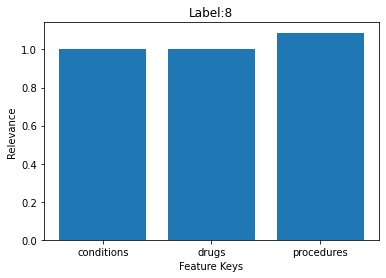

In [3]:
barPlot = []
barCategories = []
for key in sorted(rel_scores.keys()):
    barPlot.append(float(rel_scores[key].view(-1).detach().cpu()))
    barCategories.append(key)

print(barPlot)
plt.xlabel("Feature Keys")
plt.ylabel("Relevance")
plt.title("Label:" + str(sample['label']))
plt.bar(barCategories, barPlot)